# Wikipedia pages graph from seed page

In [1]:
import networkx as nx
import wikipedia
from wikipedia import DisambiguationError, PageError
import matplotlib.pyplot as plt

Set the seed page and the search depth. The search depth is the number of
layers of neighbors to include in the network. e.g., if the search depth is 1,
the network will include the seed page and all pages linked from the seed page.

In [2]:
SEARCH_DEPTH = 1  #Set the search depth here                       
SEED = "Roma Tre"  #Set the seed page here

STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "Geographic coordinate system",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier",
         "Pubmed Central",
         "Digital Object Identifier",
         "Arxiv",
         "Proc Natl Acad Sci Usa",
         "Bibcode",
         "Library Of Congress Control Number",
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")


## 1.1 Setting up fringe and visited sets

In [3]:
SEED = SEED.title()
fringe = [(0, SEED)]  # The queue of pages we have found but not yet visited
done_set = set()  # The set of pages we have visited
g = nx.DiGraph()  # The networkx graph, directed


## 1.2 Load the seed page
Check whether the seed page exists.

In [4]:
import sys

layer, page = 0, SEED

try:
    source = wikipedia.page(SEED, auto_suggest=False)
    done_set.add(SEED)
    print(source.url)
    print(f"Page loaded, adding {len(source.links)} subpages")
except (DisambiguationError, PageError):
    print(f"Could not load seed {SEED}")
    print("Check if the page exists.")
    sys.exit(1)

https://en.wikipedia.org/wiki/Roma_Tre_University
Page loaded, adding 293 subpages


## 1.3 Build the network
Using Breadth First Search (BFS) to build the network.

In [5]:
%%time

progress = {"nodes": [], "fringe": []}

while fringe:
    
    print(f"{layer} - {page}, nodes: {len(done_set)}, fringe: {len(fringe)}")
    layer, page = fringe.pop(0)
    
    progress["nodes"].append(len(done_set))
    progress["fringe"].append(len(fringe))
    
    try:
        links = wikipedia.page(page).links
    except (DisambiguationError, PageError):
        print(f"Error retrieving links from {page}")
        continue

    for link in links:
        g.add_edge(page, link)
        if link not in STOPS and link not in done_set and not link.startswith("List of"):
            done_set.add(link)
            if layer < SEARCH_DEPTH:
                fringe.append((layer + 1, link))


0 - Roma Tre, nodes: 1, fringe: 1


KeyError: ('nodes', 'fringe')

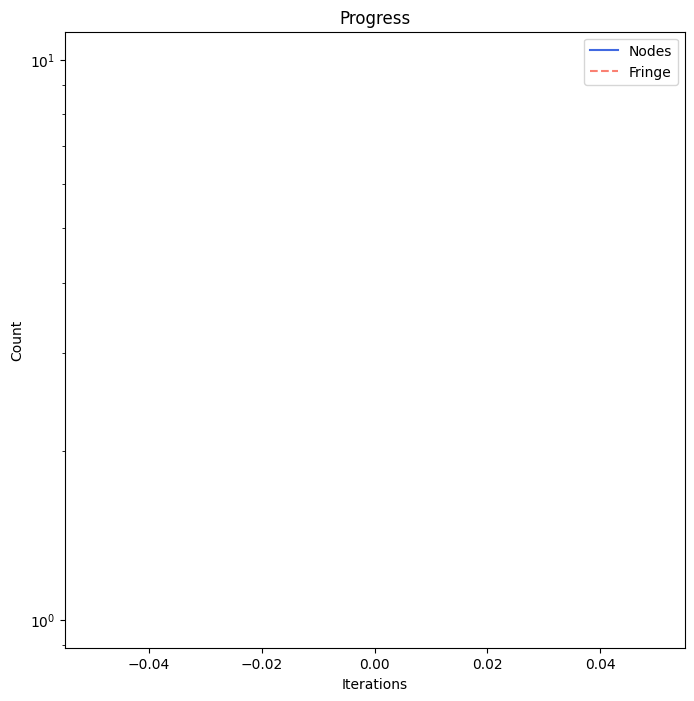

In [6]:
#plotting the progress
plt.figure("Progress", figsize=(8, 8))
plt.plot(progress["nodes"], label="Nodes", color="royalblue", linestyle="-")
plt.plot(progress["fringe"], label="Fringe", color="salmon", linestyle="--")
# log scale
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Count")
plt.title("Progress")
plt.legend()
plt.show()


In [7]:
print(f"{g.number_of_nodes()} nodes, {g.number_of_edges()} edges")

0 nodes, 0 edges


## 1.4 Explore the network

In [8]:
import numpy as np

degree_sequence = sorted((d for _, d in g.degree()))

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence)
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_yscale("log")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_xlim([0, 100])
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_yscale("log")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x76433c304180> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 800x800 with 2 Axes>

## 1.5 Save the graph in Gephi readable format

In [ ]:
nx.write_gexf(g, f"graphs/{SEED}_d{SEARCH_DEPTH}.gexf")